首先,加载数据集。 Fashion MNIST是MNIST的直接替代品。 它具有与MNIST完全相同的格式（70,000张灰度图像，每幅28×28像素，具有10个类别），但是这些图像代表的是时尚商品，而不是手写数字，因此每个类别都更加多样化，问题就变得比MNIST更具挑战性。例如，简单的线性模型在MNIST上达到约92％的精度，但在Fashion MNIST上仅达到约83％的精度。
使用Keras加载数据集 Keras提供了一些实用程序功能来获取和加载常见数据集，包括MNIST和Fashion MNIST。所以接下来我们通过keras加载数据集

In [1]:
import tensorflow as tf
from tensorflow import keras

fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

当使用Keras而不是Scikit-Learn加载Fashion MNIST时，一个重要的区别是每个图像都表示为28×28数组，而不是大小为784的1维数组。此外，像素强度表示为整数（从0开始 到255），而不是浮点数（从0.0到255.0）。 由于我们要使用梯度下降训练神经网络，因此必须缩放输入特征。 为简单起见，我们将像素强度除以255.0（将其转换为浮点数），将像素强度降低到0–1范围：

In [2]:
X_train_full.shape

(60000, 28, 28)

In [3]:
#划分验证集,也可以在后续直接指定validation_split来划分
# X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
# y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_train = X_train_full / 255.
y_train = y_train_full
X_test = X_test / 255.
y_test = y_test

In [4]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
# 设定图片保存路径，这里写了一个函数，后面直接调用即可
PROJECT_ROOT_DIR = os.path.abspath('.')   # 表示当前所处的文件夹的绝对路径
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
print(IMAGES_PATH)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

D:\workplace\notebook\ML_Final\images


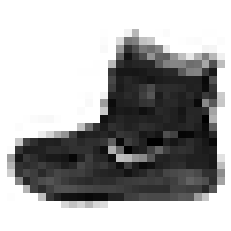

In [5]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

In [6]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
class_names[y_train[0]]

'Ankle boot'

Saving figure fashion_mnist_plot


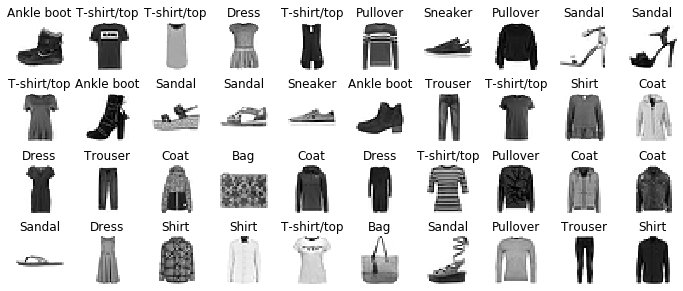

In [7]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

In [9]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

使用Sequential API创建模型 现在建立神经网络！这是具有两个隐藏层的分类MLP
首先创建一个Sequential模型。这是用于神经网络的最简单的Keras模型，它仅由顺序连接的单层堆栈组成。这称为Sequential API。
接下来，我们构建第一层并将其添加到模型中。它是Flatten层，其作用是将每个输入图像转换为一维数组：如果接收到输入数据X，则计算X.reshape（-1，1）。该层没有任何参数。它只是在那里做一些简单的预处理。由于它是模型中的第一层，因此应该指定input_shape，其中不包括批次大小，而仅包括实例的形状。或者，您可以添加keras.layers.InputLayer作为第一层，设置input_shape = [28,28]。
接下来，我们添加具有300个神经元的密集隐藏层。它将使用ReLU激活功能。每个密集层管理自己的权重矩阵，其中包含神经元及其输入之间的所有连接权重。它还管理一个偏项的向量（每个神经元一个）。当它接收到一些输入数据时，它将计算公式10-2。
然后，我们还使用ReLU激活功能添加第二个具有100个神经元的密集隐藏层。
最后，我们使用softmax激活函数添加一个包含10个神经元的密集输出层（每个类一个）（因为这些类是排他的）。

In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

创建模型后，必须调用其compile（）方法以指定损失函数和要使用的优化器。 
首先，我们使用“ sparse_categorical_crossentropy”损失，因为我们具有稀疏标签（即，对于每个实例，只有一个目标类索引，在这种情况下为0到9），并且这些类是互斥的。 相反，如果每个实例的每个类都有一个目标概率（例如单热向量，例如[0.，0.，0.，1.，0.，0.，0.，0.，0.，0 。]代表类别3），则我们需要使用“ categorical_crossentropy”损失。 如果我们正在执行二进制分类（带有一个或多个二进制标签），则将在输出层中使用“ Sigmoid”（即逻辑）激活函数，而不是“ softmax”激活函数，并且将使用“ binary_crossentropy” “ 损失。
关于优化器，“ sgd”表示我们将使用简单的随机梯度下降训练模型。 换句话说，Keras将执行先前所述的反向传播算法（即，反向autodiff+梯度下降）。 
使用SGD优化器时，调整学习速率很重要。 因此，通常需要使用optimizer = keras.optimizers.SGD（lr = ???）来设置学习速率，而不是使用optimizer =“ sgd”（默认值为lr = 0.01）。

最后，由于这是一个分类器，所以在训练和评估期间测量其“准确性”是有意义的。

In [12]:
history1 = model.fit(X_train, y_train, epochs=30,
                    validation_split = 0.1)
#默认lr=0.01

Train on 54000 samples, validate on 6000 samples
Epoch 1/30
54000/54000 [==============================] - 11s 203us/sample - loss: 0.7016 - acc: 0.7690 - val_loss: 0.5464 - val_acc: 0.7987
Epoch 2/30
54000/54000 [==============================] - 11s 195us/sample - loss: 0.4852 - acc: 0.8314 - val_loss: 0.4735 - val_acc: 0.8265
Epoch 3/30
54000/54000 [==============================] - 11s 206us/sample - loss: 0.4415 - acc: 0.8462 - val_loss: 0.4407 - val_acc: 0.8440
Epoch 4/30
54000/54000 [==============================] - 11s 210us/sample - loss: 0.4139 - acc: 0.8552 - val_loss: 0.4061 - val_acc: 0.8555
Epoch 5/30
54000/54000 [==============================] - 11s 201us/sample - loss: 0.3938 - acc: 0.8617 - val_loss: 0.4256 - val_acc: 0.8533
Epoch 6/30
54000/54000 [==============================] - 11s 212us/sample - loss: 0.3790 - acc: 0.8666 - val_loss: 0.3818 - val_acc: 0.8658
Epoch 7/30
54000/54000 [==============================] - 11s 198us/sample - loss: 0.3652 - acc: 0.8718 -

我们将输入特征（X_train）和目标类（y_train）以及要训练epochs数传递给它（否则它将默认设置为1，这绝对不足以收敛为一个好的解决方案）。我们还传递了一个验证集（这是可选的）。 Keras将在每个epoch结束时测量此集合上的损失和额外指标，这对于查看模型的实际效果非常有用。如果训练集的性能比验证集的性能好得多，则模型可能过训练（或者存在错误，例如训练集和验证集之间的数据不匹配）。
在训练期间的每个epoch，Keras会显示到目前为止已处理的实例数（以及进度条），每个样本的平均训练时间，损失和准确性（或您要求的任何其他额外指标） （针对训练集和验证集）。可以看到训练损失减少了，这是一个好兆头，经过30个epoch后，验证准确性达到了89.30％。这与训练的准确性相差不大，因此看起来没有过训练。

Saving figure learning_curves_plot


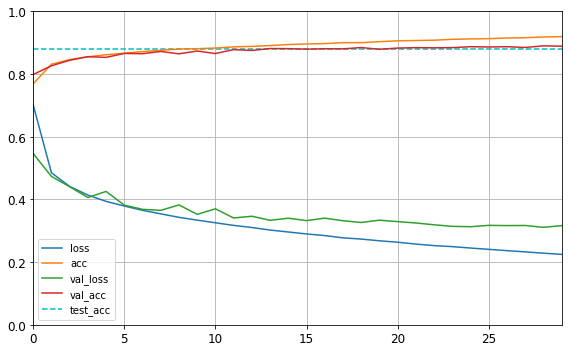

In [23]:
import pandas as pd
import numpy as np

pd.DataFrame(history1.history).plot(figsize=(8, 5))
# t = np.arange(0,31,0.1)
# tt = test1[1] + t*0
# plt.plot(t,tt)
plt.hlines(test1[1],0,30,colors = "c", linestyles = "dashed",label = 'test_acc')
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.legend()
save_fig("learning_curves_plot")
plt.show()

可以看到，训练期间，训练准确性和验证准确性都在稳步提高，而训练损失和验证损失却在减少。  而且，验证曲线接近训练曲线，这意味着没有太多的过拟合。 在刚开始的特殊情况下，该模型看起来在验证集上的表现要好于训练开始时在训练集上的表现。 但事实并非如此：验证误差是在每个时期结束时计算的，而训练误差是在每个时期期间使用移动平均值计算的。 因此，训练曲线应向左移动半个epoch。 如果这样做，会看到训练和验证曲线在训练开始时几乎完全重叠。
训练集的性能最终会超过验证性能，这通常是训练足够长时间的情况。您可以说模型尚未完全收敛，因为验证损失仍在下降，因此可能应该继续训练。就像再次调用fit（）方法一样简单，因为Keras只是继续从中断处继续训练

In [13]:
test1 = model.evaluate(X_test, y_test)

10000/10000 [==============================] - 1s 128us/sample - loss: 0.3394 - acc: 0.8801


In [16]:
test1[1]

0.8801

如果对模型的性能不满意，则应返回并调整超参数。首先要检查的是学习率。如果这样做没有帮助，可以尝试使用另一个优化器（并在更改任何超参数后始终重新调整学习率）。如果性能仍然不佳，请尝试调整模型超参数，例如层数，每层神经元数以及用于每个隐藏层的激活函数的类型。还可以尝试调整其他超参数，例如批处理大小（可以使用batch_size参数在fit（）方法中设置，默认为32）。

接下来，通过改变验证集的大小来观察其是否对改善模型的性能有作业。

In [24]:
model2 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [25]:
model2.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [26]:
history2 = model2.fit(X_train, y_train, epochs=30,
                    validation_split = 0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/30
48000/48000 [==============================] - 11s 233us/sample - loss: 0.7463 - acc: 0.7601 - val_loss: 0.5362 - val_acc: 0.8165
Epoch 2/30
48000/48000 [==============================] - 10s 210us/sample - loss: 0.4933 - acc: 0.8289 - val_loss: 0.4711 - val_acc: 0.8372
Epoch 3/30
48000/48000 [==============================] - 10s 200us/sample - loss: 0.4480 - acc: 0.8438 - val_loss: 0.4409 - val_acc: 0.8436
Epoch 4/30
48000/48000 [==============================] - 10s 202us/sample - loss: 0.4210 - acc: 0.8529 - val_loss: 0.4241 - val_acc: 0.8477
Epoch 5/30
48000/48000 [==============================] - 10s 210us/sample - loss: 0.3983 - acc: 0.8595 - val_loss: 0.4113 - val_acc: 0.8540
Epoch 6/30
48000/48000 [==============================] - 10s 207us/sample - loss: 0.3817 - acc: 0.8665 - val_loss: 0.3886 - val_acc: 0.8632
Epoch 7/30
48000/48000 [==============================] - 11s 235us/sample - loss: 0.3694 - acc: 0.8704 

In [27]:
test2 = model2.evaluate(X_test, y_test)

10000/10000 [==============================] - 2s 182us/sample - loss: 0.3493 - acc: 0.8753


Saving figure learning_curves_plot_2


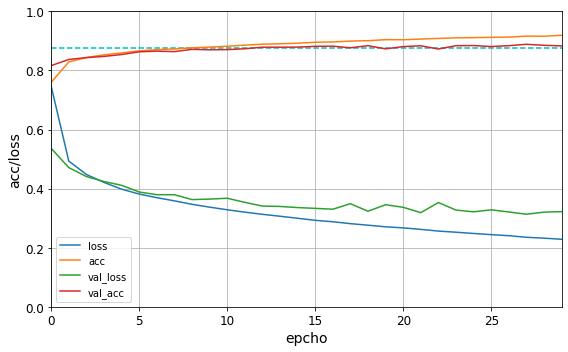

In [28]:
pd.DataFrame(history2.history).plot(figsize=(8, 5))
plt.hlines(test2[1],0,30,colors = "c", linestyles = "dashed",label = 'test_acc')
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.xlabel('epcho')
plt.ylabel('acc/loss')
save_fig("learning_curves_plot_2")
plt.show()

In [29]:
data1 = pd.DataFrame(history1.history)
data2 = pd.DataFrame(history2.history)

Saving figure performance of different val_data scale


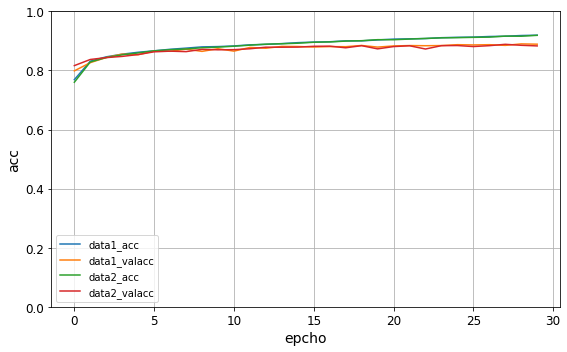

In [30]:
fig = plt.figure(num = 1,figsize=(8,5))
plt.plot(data1['acc'],label = 'data1_acc')
plt.plot(data1['val_acc'],label = 'data1_valacc')
plt.plot(data2['acc'],label = 'data2_acc')
plt.plot(data2['val_acc'],label = 'data2_valacc')
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.xlabel('epcho')
plt.ylabel('acc')
plt.legend()
save_fig("performance of different val_data scale")
plt.show()

In [31]:
model3 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [32]:
model3.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr = 0.05),
              metrics=["accuracy"])

In [33]:
history3 = model3.fit(X_train, y_train, epochs=30,
                    validation_split = 0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/30
54000/54000 [==============================] - 12s 214us/sample - loss: 0.5573 - acc: 0.8040 - val_loss: 0.4468 - val_acc: 0.8367
Epoch 2/30
54000/54000 [==============================] - 11s 198us/sample - loss: 0.3991 - acc: 0.8559 - val_loss: 0.4099 - val_acc: 0.8540
Epoch 3/30
54000/54000 [==============================] - 11s 203us/sample - loss: 0.3575 - acc: 0.8685 - val_loss: 0.3572 - val_acc: 0.8707
Epoch 4/30
54000/54000 [==============================] - 11s 201us/sample - loss: 0.3315 - acc: 0.8783 - val_loss: 0.3824 - val_acc: 0.8602
Epoch 5/30
54000/54000 [==============================] - 11s 200us/sample - loss: 0.3122 - acc: 0.8854 - val_loss: 0.3561 - val_acc: 0.8655
Epoch 6/30
54000/54000 [==============================] - 12s 224us/sample - loss: 0.2960 - acc: 0.8902 - val_loss: 0.3582 - val_acc: 0.8687
Epoch 7/30
54000/54000 [==============================] - 11s 205us/sample - loss: 0.2826 - acc: 0.8942 -

In [34]:
test3 = model3.evaluate(X_test, y_test)

10000/10000 [==============================] - 1s 133us/sample - loss: 0.3731 - acc: 0.8890


In [35]:
model4 = keras.models.Sequential([
keras.layers.Flatten(input_shape=[28, 28]),
keras.layers.Dense(300, activation="relu"),
keras.layers.Dense(100, activation="relu"),
keras.layers.Dense(10, activation="softmax")
])

model4.compile(loss="sparse_categorical_crossentropy",
          optimizer=keras.optimizers.SGD(lr = 0.005),
          metrics=["accuracy"])

history4 = model4.fit(X_train, y_train, epochs=30,
                validation_split = 0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/30
54000/54000 [==============================] - 13s 245us/sample - loss: 0.8460 - acc: 0.7371 - val_loss: 0.5858 - val_acc: 0.8067
Epoch 2/30
54000/54000 [==============================] - 11s 197us/sample - loss: 0.5405 - acc: 0.8183 - val_loss: 0.5240 - val_acc: 0.8200
Epoch 3/30
54000/54000 [==============================] - 11s 196us/sample - loss: 0.4834 - acc: 0.8341 - val_loss: 0.4721 - val_acc: 0.8385
Epoch 4/30
54000/54000 [==============================] - 11s 199us/sample - loss: 0.4545 - acc: 0.8416 - val_loss: 0.4467 - val_acc: 0.8437
Epoch 5/30
54000/54000 [==============================] - 11s 200us/sample - loss: 0.4339 - acc: 0.8492 - val_loss: 0.4440 - val_acc: 0.8410
Epoch 6/30
54000/54000 [==============================] - 12s 231us/sample - loss: 0.4185 - acc: 0.8536 - val_loss: 0.4189 - val_acc: 0.8527
Epoch 7/30
54000/54000 [==============================] - 13s 234us/sample - loss: 0.4066 - acc: 0.8588 -

In [36]:
test4 = model4.evaluate(X_test, y_test)

10000/10000 [==============================] - 1s 136us/sample - loss: 0.3580 - acc: 0.8732


In [37]:
model5 = keras.models.Sequential([
keras.layers.Flatten(input_shape=[28, 28]),
keras.layers.Dense(300, activation="relu"),
keras.layers.Dense(100, activation="relu"),
keras.layers.Dense(10, activation="softmax")
])

model5.compile(loss="sparse_categorical_crossentropy",
          optimizer=keras.optimizers.SGD(lr = 0.001),
          metrics=["accuracy"])

history5 = model5.fit(X_train, y_train, epochs=30,
                validation_split = 0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/30
54000/54000 [==============================] - 12s 222us/sample - loss: 1.4687 - acc: 0.5896 - val_loss: 1.0161 - val_acc: 0.6875
Epoch 2/30
54000/54000 [==============================] - 13s 242us/sample - loss: 0.8912 - acc: 0.7136 - val_loss: 0.7778 - val_acc: 0.7550
Epoch 3/30
54000/54000 [==============================] - 13s 236us/sample - loss: 0.7388 - acc: 0.7620 - val_loss: 0.6795 - val_acc: 0.7798
Epoch 4/30
54000/54000 [==============================] - 15s 274us/sample - loss: 0.6606 - acc: 0.7881 - val_loss: 0.6220 - val_acc: 0.7975
Epoch 5/30
54000/54000 [==============================] - 12s 215us/sample - loss: 0.6107 - acc: 0.8028 - val_loss: 0.5834 - val_acc: 0.8068
Epoch 6/30
54000/54000 [==============================] - 11s 204us/sample - loss: 0.5761 - acc: 0.8104 - val_loss: 0.5578 - val_acc: 0.8152
Epoch 7/30
54000/54000 [==============================] - 13s 243us/sample - loss: 0.5506 - acc: 0.8177 -

In [38]:
test5 = model5.evaluate(X_test, y_test)

10000/10000 [==============================] - 1s 128us/sample - loss: 0.4404 - acc: 0.8439


In [39]:
model6 = keras.models.Sequential([
keras.layers.Flatten(input_shape=[28, 28]),
keras.layers.Dense(300, activation="relu"),
keras.layers.Dense(100, activation="relu"),
keras.layers.Dense(10, activation="softmax")
])

model6.compile(loss="sparse_categorical_crossentropy",
          optimizer=keras.optimizers.SGD(lr = 0.02),
          metrics=["accuracy"])

history6 = model6.fit(X_train, y_train, epochs=30,
                validation_split = 0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/30
54000/54000 [==============================] - 13s 238us/sample - loss: 0.6347 - acc: 0.7854 - val_loss: 0.4836 - val_acc: 0.8310
Epoch 2/30
54000/54000 [==============================] - 14s 261us/sample - loss: 0.4477 - acc: 0.8421 - val_loss: 0.4459 - val_acc: 0.8350
Epoch 3/30
54000/54000 [==============================] - 14s 268us/sample - loss: 0.4027 - acc: 0.8580 - val_loss: 0.4057 - val_acc: 0.8520
Epoch 4/30
54000/54000 [==============================] - 12s 223us/sample - loss: 0.3729 - acc: 0.8669 - val_loss: 0.3838 - val_acc: 0.8620
Epoch 5/30
54000/54000 [==============================] - 11s 206us/sample - loss: 0.3518 - acc: 0.8745 - val_loss: 0.3793 - val_acc: 0.8613
Epoch 6/30
54000/54000 [==============================] - 11s 205us/sample - loss: 0.3353 - acc: 0.8796 - val_loss: 0.3573 - val_acc: 0.8732
Epoch 7/30
54000/54000 [==============================] - 12s 227us/sample - loss: 0.3216 - acc: 0.8828 -

In [40]:
test6 = model6.evaluate(X_test, y_test)

10000/10000 [==============================] - 1s 136us/sample - loss: 0.3440 - acc: 0.8886


In [41]:
model7 = keras.models.Sequential([
keras.layers.Flatten(input_shape=[28, 28]),
keras.layers.Dense(300, activation="relu"),
keras.layers.Dense(100, activation="relu"),
keras.layers.Dense(10, activation="softmax")
])

model7.compile(loss="sparse_categorical_crossentropy",
          optimizer=keras.optimizers.SGD(lr = 0.003),
          metrics=["accuracy"])

history7 = model7.fit(X_train, y_train, epochs=30,
                validation_split = 0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/30
54000/54000 [==============================] - 12s 224us/sample - loss: 1.0111 - acc: 0.6939 - val_loss: 0.6837 - val_acc: 0.7737
Epoch 2/30
54000/54000 [==============================] - 11s 196us/sample - loss: 0.6228 - acc: 0.7953 - val_loss: 0.5678 - val_acc: 0.8053
Epoch 3/30
54000/54000 [==============================] - 11s 207us/sample - loss: 0.5459 - acc: 0.8163 - val_loss: 0.5169 - val_acc: 0.8212
Epoch 4/30
54000/54000 [==============================] - 11s 203us/sample - loss: 0.5057 - acc: 0.8268 - val_loss: 0.4904 - val_acc: 0.8252
Epoch 5/30
54000/54000 [==============================] - 11s 200us/sample - loss: 0.4810 - acc: 0.8349 - val_loss: 0.4785 - val_acc: 0.8307
Epoch 6/30
54000/54000 [==============================] - 11s 206us/sample - loss: 0.4624 - acc: 0.8395 - val_loss: 0.4597 - val_acc: 0.8372
Epoch 7/30
54000/54000 [==============================] - 12s 227us/sample - loss: 0.4476 - acc: 0.8448 -

In [42]:
test7 = model7.evaluate(X_test, y_test)

10000/10000 [==============================] - 2s 152us/sample - loss: 0.3761 - acc: 0.8668


Saving figure model performance on different lr


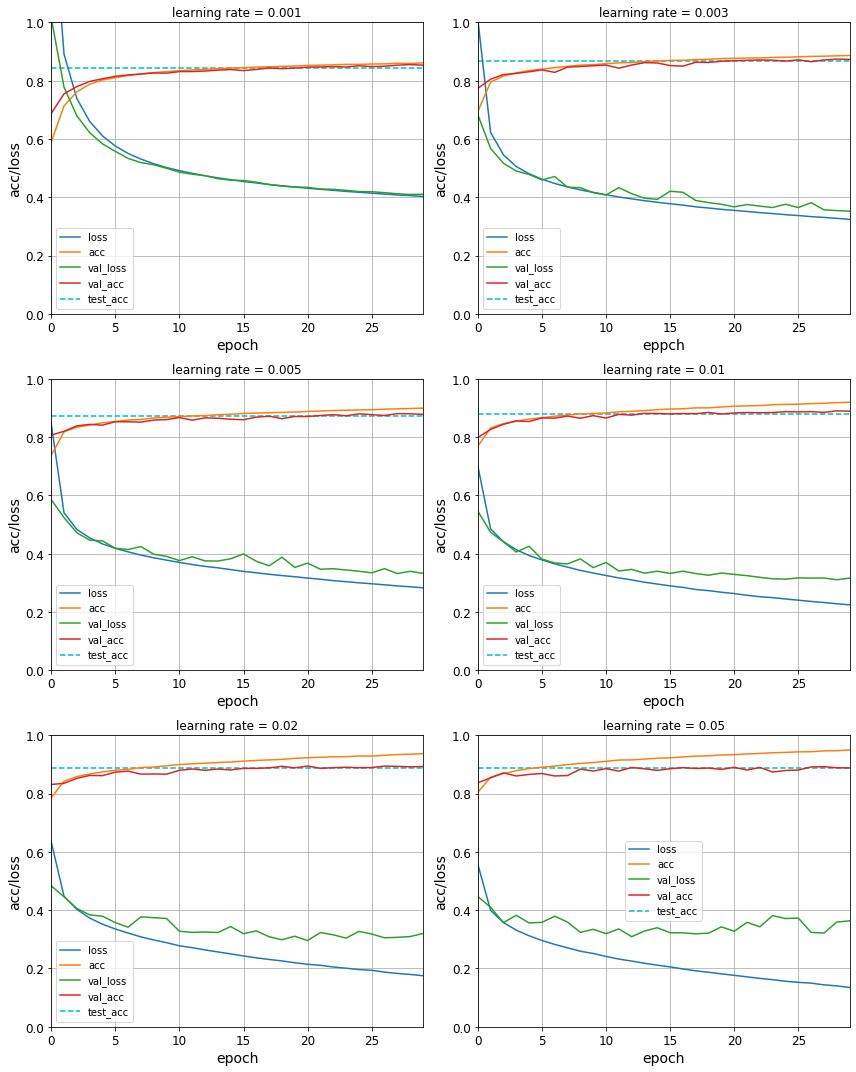

In [45]:
fig = plt.figure(figsize=(12,15))

ax1 = fig.add_subplot(3,2,1)
ax2 = fig.add_subplot(3,2,2) 
ax3 = fig.add_subplot(3,2,3) 
ax4 = fig.add_subplot(3,2,4) 
ax5 = fig.add_subplot(3,2,5) 
ax6 = fig.add_subplot(3,2,6)

pd.DataFrame(history5.history).plot(ax = ax1,grid = True)
pd.DataFrame(history7.history).plot(ax = ax2,grid = True)
pd.DataFrame(history4.history).plot(ax = ax3,grid = True)
pd.DataFrame(history1.history).plot(ax = ax4,grid = True)
pd.DataFrame(history6.history).plot(ax = ax5,grid = True)
pd.DataFrame(history3.history).plot(ax = ax6,grid = True)

ax1.hlines(test5[1],0,30,colors = "c", linestyles = "dashed",label = 'test_acc')
ax1.set_title('learning rate = 0.001')
ax1.set_ylim(0, 1)
ax1.set_xlabel('epoch')
ax1.set_ylabel('acc/loss')
ax1.legend()
ax2.hlines(test7[1],0,30,colors = "c", linestyles = "dashed",label = 'test_acc')
ax2.set_title('learning rate = 0.003')
ax2.set_ylim(0, 1)
ax2.set_xlabel('eppch')
ax2.set_ylabel('acc/loss')
ax2.legend()
ax3.hlines(test4[1],0,30,colors = "c", linestyles = "dashed",label = 'test_acc')
ax3.set_title('learning rate = 0.005')
ax3.set_ylim(0, 1)
ax3.set_xlabel('epoch')
ax3.set_ylabel('acc/loss')
ax3.legend()
ax4.hlines(test1[1],0,30,colors = "c", linestyles = "dashed",label = 'test_acc')
ax4.set_title('learning rate = 0.01')
ax4.set_ylim(0, 1)
ax4.set_xlabel('epoch')
ax4.set_ylabel('acc/loss')
ax4.legend()
ax5.hlines(test6[1],0,30,colors = "c", linestyles = "dashed",label = 'test_acc')
ax5.set_title('learning rate = 0.02')
ax5.set_ylim(0, 1)
ax5.set_xlabel('epoch')
ax5.set_ylabel('acc/loss')
ax5.legend()
ax6.hlines(test3[1],0,30,colors = "c", linestyles = "dashed",label = 'test_acc')
ax6.set_title('learning rate = 0.05')
ax6.set_ylim(0, 1)
ax6.set_xlabel('epoch')
ax6.set_ylabel('acc/loss')
ax6.legend()

save_fig('model performance on different lr')
plt.show()

通过分析上述结果，我们发现在学习率为0.001时，模型的在训练集和验证集上的拟合情况最好，而且通过测试集在不同模型上的测试，我们也发现，在学习率为0.001时，模型的过拟合程度是最轻的，模型的拟合情况更好。所以我们将在之后的分析中都将以0.001作为模型的学习率。

接下来，将从其他超参数的角度来分析其对模型性能的影响，包括优化器、批量大小和激活函数。由于FashionMnist数据集规模并不大，梯度下降的速度对模型训练时间的影响可能意义不大，所以接下来我们将从激活函数的角度来分析其对模型性能的影响。

Saving figure activation_functions_plot


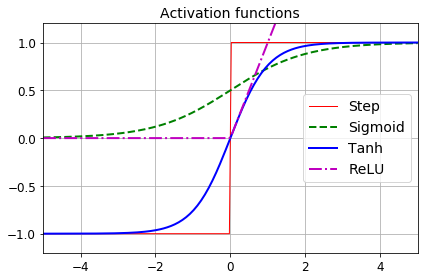

In [49]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

# def derivative(f, z, eps=0.000001):
#     return (f(z + eps) - f(z - eps))/(2 * eps)

z = np.linspace(-5, 5, 200)

# plt.figure(figsize=(11,4))

# plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

# plt.subplot(122)
# plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
# plt.plot(0, 0, "ro", markersize=5)
# plt.plot(0, 0, "rx", markersize=10)
# plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
# plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
# plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
# plt.grid(True)
# #plt.legend(loc="center right", fontsize=14)
# plt.title("Derivatives", fontsize=14)
# plt.axis([-5, 5, -0.2, 1.2])

save_fig("activation_functions_plot")
plt.show()

In [50]:
model8 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal",activation="sigmoid"),
    keras.layers.Dense(100, kernel_initializer="he_normal",activation="sigmoid"),
    keras.layers.Dense(10, activation="softmax")
])
model8.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])
history8 = model8.fit(X_train, y_train, epochs=30,
                    validation_split = 0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/30
54000/54000 [==============================] - 13s 243us/sample - loss: 2.2935 - acc: 0.1819 - val_loss: 2.2577 - val_acc: 0.3698
Epoch 2/30
54000/54000 [==============================] - 12s 216us/sample - loss: 2.2276 - acc: 0.4386 - val_loss: 2.1948 - val_acc: 0.5635
Epoch 3/30
54000/54000 [==============================] - 11s 203us/sample - loss: 2.1615 - acc: 0.5517 - val_loss: 2.1246 - val_acc: 0.6258
Epoch 4/30
54000/54000 [==============================] - 11s 208us/sample - loss: 2.0852 - acc: 0.6152 - val_loss: 2.0411 - val_acc: 0.6523
Epoch 5/30
54000/54000 [==============================] - 11s 207us/sample - loss: 1.9954 - acc: 0.6409 - val_loss: 1.9452 - val_acc: 0.6523
Epoch 6/30
54000/54000 [==============================] - 11s 208us/sample - loss: 1.8930 - acc: 0.6484 - val_loss: 1.8372 - val_acc: 0.6708
Epoch 7/30
54000/54000 [==============================] - 12s 216us/sample - loss: 1.7834 - acc: 0.6512 -

In [51]:
test8 = model8.evaluate(X_test, y_test)

10000/10000 [==============================] - 2s 150us/sample - loss: 0.8363 - acc: 0.7227


In [52]:
model9 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal",activation="tanh"),
    keras.layers.Dense(100, kernel_initializer="he_normal",activation="tanh"),
    keras.layers.Dense(10, activation="softmax")
])
model9.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])
history9 = model9.fit(X_train, y_train, epochs=30,
                    validation_split = 0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/30
54000/54000 [==============================] - 14s 261us/sample - loss: 1.1784 - acc: 0.6380 - val_loss: 0.8506 - val_acc: 0.7222
Epoch 2/30
54000/54000 [==============================] - 13s 236us/sample - loss: 0.7737 - acc: 0.7532 - val_loss: 0.7013 - val_acc: 0.7707
Epoch 3/30
54000/54000 [==============================] - 11s 207us/sample - loss: 0.6714 - acc: 0.7813 - val_loss: 0.6348 - val_acc: 0.7858
Epoch 4/30
54000/54000 [==============================] - 13s 236us/sample - loss: 0.6157 - acc: 0.7978 - val_loss: 0.5906 - val_acc: 0.7987
Epoch 5/30
54000/54000 [==============================] - 15s 286us/sample - loss: 0.5791 - acc: 0.8074 - val_loss: 0.5624 - val_acc: 0.8063
Epoch 6/30
54000/54000 [==============================] - 14s 258us/sample - loss: 0.5528 - acc: 0.8141 - val_loss: 0.5414 - val_acc: 0.8158
Epoch 7/30
54000/54000 [==============================] - 13s 247us/sample - loss: 0.5327 - acc: 0.8203 -

In [53]:
test9 = model9.evaluate(X_test, y_test)

10000/10000 [==============================] - 1s 134us/sample - loss: 0.4360 - acc: 0.8458


In [88]:
import numpy as np
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

Saving figure leaky_relu_plot


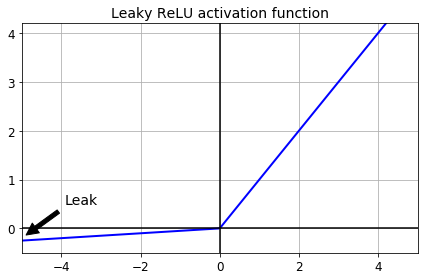

In [89]:
z = np.linspace(-5, 5, 200)

plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

In [54]:
model10 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])
model10.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])
history10 = model10.fit(X_train, y_train, epochs=30,
                    validation_split = 0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/30
54000/54000 [==============================] - 13s 242us/sample - loss: 1.2373 - acc: 0.6305 - val_loss: 0.8513 - val_acc: 0.7338
Epoch 2/30
54000/54000 [==============================] - 11s 208us/sample - loss: 0.7773 - acc: 0.7444 - val_loss: 0.6947 - val_acc: 0.7733
Epoch 3/30
54000/54000 [==============================] - 12s 223us/sample - loss: 0.6714 - acc: 0.7798 - val_loss: 0.6314 - val_acc: 0.7930
Epoch 4/30
54000/54000 [==============================] - 11s 212us/sample - loss: 0.6143 - acc: 0.7993 - val_loss: 0.5893 - val_acc: 0.8050
Epoch 5/30
54000/54000 [==============================] - 12s 221us/sample - loss: 0.5761 - acc: 0.8104 - val_loss: 0.5569 - val_acc: 0.8127
Epoch 6/30
54000/54000 [==============================] - 13s 238us/sample - loss: 0.5489 - acc: 0.8183 - val_loss: 0.5377 - val_acc: 0.8160
Epoch 7/30
54000/54000 [==============================] - 12s 217us/sample - loss: 0.5286 - acc: 0.8222 -

In [56]:
test10 = model10.evaluate(X_test, y_test)

10000/10000 [==============================] - 2s 154us/sample - loss: 0.4421 - acc: 0.8454


In [57]:
model11 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal",activation="relu"),
    keras.layers.Dense(100, kernel_initializer="he_normal",activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
model11.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])
history11 = model11.fit(X_train, y_train, epochs=30,
                    validation_split = 0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/30
54000/54000 [==============================] - 14s 264us/sample - loss: 1.4236 - acc: 0.5808 - val_loss: 0.9381 - val_acc: 0.7207
Epoch 2/30
54000/54000 [==============================] - 17s 317us/sample - loss: 0.8273 - acc: 0.7421 - val_loss: 0.7279 - val_acc: 0.7702
Epoch 3/30
54000/54000 [==============================] - 13s 237us/sample - loss: 0.6939 - acc: 0.7798 - val_loss: 0.6447 - val_acc: 0.7940
Epoch 4/30
54000/54000 [==============================] - 11s 213us/sample - loss: 0.6268 - acc: 0.7981 - val_loss: 0.5979 - val_acc: 0.8068
Epoch 5/30
54000/54000 [==============================] - 11s 212us/sample - loss: 0.5842 - acc: 0.8086 - val_loss: 0.5655 - val_acc: 0.8157
Epoch 6/30
54000/54000 [==============================] - 12s 213us/sample - loss: 0.5549 - acc: 0.8160 - val_loss: 0.5394 - val_acc: 0.8232
Epoch 7/30
54000/54000 [==============================] - 17s 308us/sample - loss: 0.5327 - acc: 0.8228 -

In [58]:
test11 = model11.evaluate(X_test, y_test)

10000/10000 [==============================] - 1s 143us/sample - loss: 0.4301 - acc: 0.8468


Saving figure elu_plot


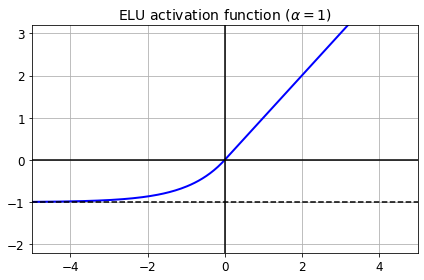

In [109]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

In [59]:
model12 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal",activation="elu"),
    keras.layers.Dense(100, kernel_initializer="he_normal",activation="elu"),
    keras.layers.Dense(10, activation="softmax")
])
model12.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])
history12 = model12.fit(X_train, y_train, epochs=30,
                    validation_split = 0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/30
54000/54000 [==============================] - 14s 256us/sample - loss: 1.1326 - acc: 0.6451 - val_loss: 0.7802 - val_acc: 0.7513
Epoch 2/30
54000/54000 [==============================] - 12s 216us/sample - loss: 0.7209 - acc: 0.7648 - val_loss: 0.6519 - val_acc: 0.7858
Epoch 3/30
54000/54000 [==============================] - 12s 216us/sample - loss: 0.6312 - acc: 0.7940 - val_loss: 0.5921 - val_acc: 0.8013
Epoch 4/30
54000/54000 [==============================] - 12s 224us/sample - loss: 0.5836 - acc: 0.8059 - val_loss: 0.5601 - val_acc: 0.8127
Epoch 5/30
54000/54000 [==============================] - 12s 219us/sample - loss: 0.5526 - acc: 0.8153 - val_loss: 0.5346 - val_acc: 0.8177
Epoch 6/30
54000/54000 [==============================] - 12s 219us/sample - loss: 0.5305 - acc: 0.8205 - val_loss: 0.5155 - val_acc: 0.8227
Epoch 7/30
54000/54000 [==============================] - 13s 246us/sample - loss: 0.5139 - acc: 0.8245 -

In [60]:
test12 = model12.evaluate(X_test, y_test)

10000/10000 [==============================] - 1s 149us/sample - loss: 0.4411 - acc: 0.8469


Saving figure selu_plot


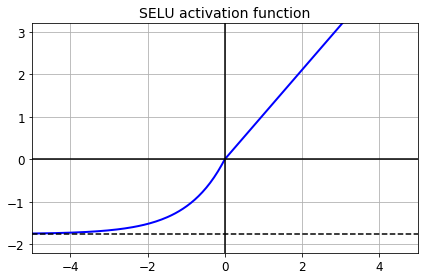

In [115]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

In [61]:
model13 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="lecun_normal",activation="selu"),
    keras.layers.Dense(100, kernel_initializer="lecun_normal",activation="selu"),
    keras.layers.Dense(10, activation="softmax")
])
model13.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])
history13 = model13.fit(X_train, y_train, epochs=30,
                    validation_split = 0.1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 54000 samples, validate on 6000 samples
Epoch 1/30
54000/54000 [==============================] - 15s 284us/sample - loss: 1.0104 - acc: 0.6832 - val_loss: 0.7059 - val_acc: 0.7680
Epoch 2/30
54000/54000 [==============================] - 18s 326us/sample - loss: 0.6561 - acc: 0.7853 - val_loss: 0.5985 - val_acc: 0.7982
Epoch 3/30
54000/54000 [==============================] - 15s 284us/sample - loss: 0.5798 - acc: 0.8063 - val_loss: 0.5484 - val_acc: 0.8128
Epoch 4/30
54000/54000 [==============================] - 13s 241us/sample - loss: 0.5392 - acc: 0.8172 - val_loss: 0.5160 - val_acc: 0.8222
Epoch 5/30
54000/54000 [==============================] - 13s 242us/sample - loss: 0.5132 - acc: 0.8252 - val_loss: 0.4969 - val_acc: 0.8273
Epoch 6/30
54000/54000 [==============================] - 14s 261us/sample - loss: 0.4944 - acc: 0.8308 - val_loss: 0.4827 - val_acc: 0.8292
Epoch 7/30


In [62]:
test13 = model13.evaluate(X_test, y_test)

10000/10000 [==============================] - 2s 216us/sample - loss: 0.4247 - acc: 0.8476


Saving figure model performance on different activation


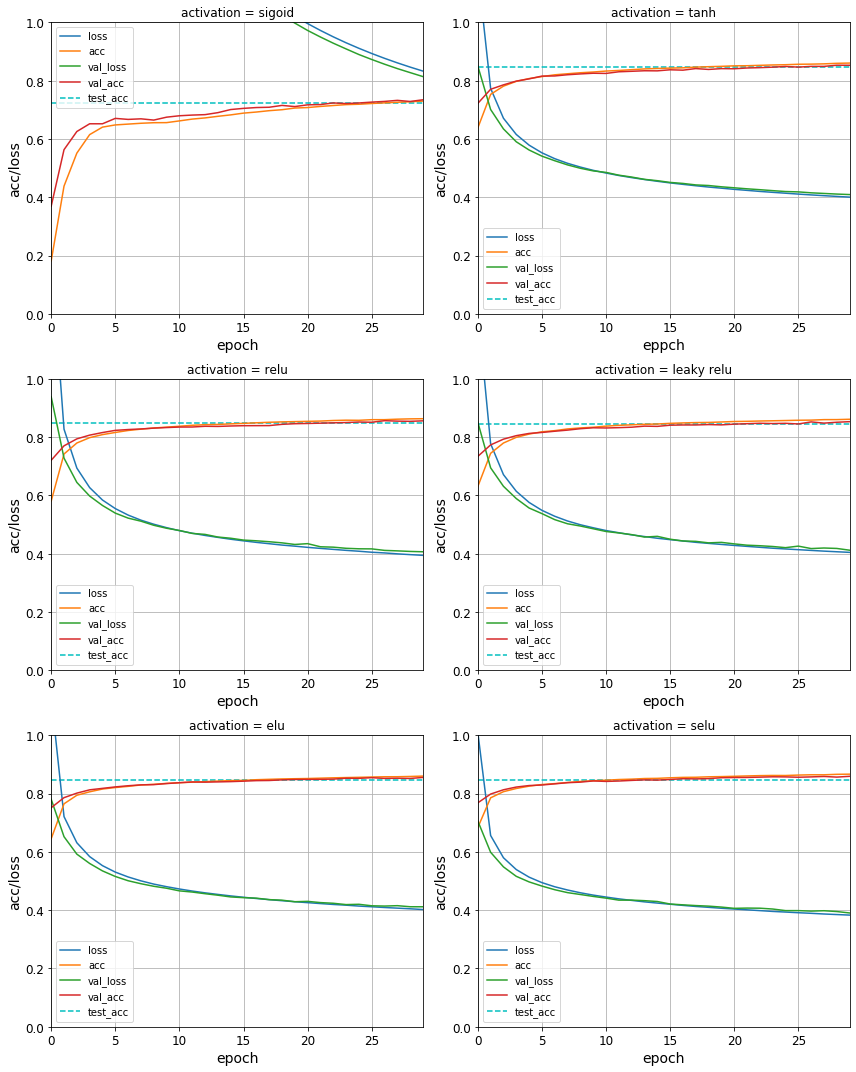

In [63]:
fig2 = plt.figure(figsize=(12,15))

ax_1 = fig2.add_subplot(3,2,1)
ax_2 = fig2.add_subplot(3,2,2) 
ax_3 = fig2.add_subplot(3,2,3) 
ax_4 = fig2.add_subplot(3,2,4) 
ax_5 = fig2.add_subplot(3,2,5) 
ax_6 = fig2.add_subplot(3,2,6)

pd.DataFrame(history8.history).plot(ax = ax_1,grid = True)
pd.DataFrame(history9.history).plot(ax = ax_2,grid = True)
pd.DataFrame(history11.history).plot(ax = ax_3,grid = True)
pd.DataFrame(history10.history).plot(ax = ax_4,grid = True)
pd.DataFrame(history12.history).plot(ax = ax_5,grid = True)
pd.DataFrame(history13.history).plot(ax = ax_6,grid = True)
ax_1.hlines(test8[1],0,30,colors = "c", linestyles = "dashed",label = 'test_acc')
ax_1.set_title('activation = sigoid')
ax_1.set_ylim(0, 1)
ax_1.set_xlabel('epoch')
ax_1.set_ylabel('acc/loss')
ax_1.legend()

ax_2.hlines(test9[1],0,30,colors = "c", linestyles = "dashed",label = 'test_acc')
ax_2.set_title('activation = tanh')
ax_2.set_ylim(0, 1)
ax_2.set_xlabel('eppch')
ax_2.set_ylabel('acc/loss')
ax_2.legend()

ax_3.hlines(test11[1],0,30,colors = "c", linestyles = "dashed",label = 'test_acc')
ax_3.set_title('activation = relu')
ax_3.set_ylim(0, 1)
ax_3.set_xlabel('epoch')
ax_3.set_ylabel('acc/loss')
ax_3.legend()

ax_4.hlines(test10[1],0,30,colors = "c", linestyles = "dashed",label = 'test_acc')
ax_4.set_title('activation = leaky relu')
ax_4.set_ylim(0, 1)
ax_4.set_xlabel('epoch')
ax_4.set_ylabel('acc/loss')
ax_4.legend()

ax_5.hlines(test12[1],0,30,colors = "c", linestyles = "dashed",label = 'test_acc')
ax_5.set_title('activation = elu')
ax_5.set_ylim(0, 1)
ax_5.set_xlabel('epoch')
ax_5.set_ylabel('acc/loss')
ax_5.legend()

ax_6.hlines(test13[1],0,30,colors = "c", linestyles = "dashed",label = 'test_acc')
ax_6.set_title('activation = selu')
ax_6.set_ylim(0, 1)
ax_6.set_xlabel('epoch')
ax_6.set_ylabel('acc/loss')
ax_6.legend()

save_fig('model performance on different activation')
plt.show()